<a href="https://colab.research.google.com/github/verneh/pytorch/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check for GPU
!nvidia-smi

Tue Nov 22 09:33:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from sklearn.datasets import make_moons

NUM_SAMPLES = 1000
RANDOM_SEED = 42

X, y = make_moons(n_samples=NUM_SAMPLES,
                  noise=0.07,
                  random_state=RANDOM_SEED)

X[:10], y[:10]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483],
        [ 0.59906425, -0.28977331],
        [ 0.29009023, -0.2046885 ],
        [-0.03826868,  0.45942924],
        [ 1.61377123, -0.2939697 ],
        [ 0.693337  ,  0.82781911]]), array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [4]:
# Turn data into a DataFrame
import pandas as pd
data_df = pd.DataFrame({"X0": X[:, 0],
                        "X1": X[:, 1],
                        "y": y})
data_df.head()

,X0,X1,y
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


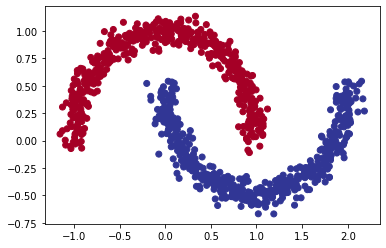

In [5]:
# Visualize the data on a plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [6]:
# Turn data into tensors
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [7]:
import torch
from torch import nn

class MoonModelV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        
        self.layer1 = nn.Linear(in_features=in_features, 
                                 out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units, 
                                 out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units,
                                out_features=out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_0 = MoonModelV0(in_features=2,
                      out_features=1,
                      hidden_units=10).to(device)
model_0

MoonModelV0(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [8]:
model_0.state_dict()

OrderedDict([('layer1.weight', tensor([[-0.0678,  0.6839],
                      [ 0.0347, -0.0326],
                      [-0.2900, -0.5817],
                      [ 0.5599, -0.5182],
                      [ 0.6879,  0.4702],
                      [-0.6648, -0.4525],
                      [ 0.6875,  0.2085],
                      [ 0.4027,  0.1502],
                      [ 0.3146,  0.6700],
                      [-0.5438,  0.4329]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.6559,  0.2254,  0.1748, -0.2326, -0.2148,  0.1875, -0.4881, -0.2035,
                       0.3532, -0.1806], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.0609,  0.0672,  0.2981, -0.1912,  0.0729,  0.0523,  0.0988, -0.1686,
                       -0.1163,  0.1748],
                      [ 0.1866, -0.1101, -0.2213,  0.1144, -0.0449, -0.0616,  0.2117,  0.1746,
                        0.1564,  0.0526],
                      [ 0.2830, -0.0494,  0.2533,  0.10

In [9]:
loss_fn = nn.BCEWithLogitsLoss() # sigmoid layer built-in
# loss_fn = nn.BCELoss() # requires sigmoid layer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of model to optimize 
                            lr=0.1) # learning rate

In [10]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
print(model_0(X_train.to(device)[:10]).squeeze())

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model_0(X_train.to(device)[:10]).squeeze()))

# Prediction probabilities
print("Pred labels:")
print(torch.round(torch.sigmoid(model_0(X_train.to(device)[:10]).squeeze())))

Logits:
tensor([-0.3375, -0.1534, -0.2069, -0.1994, -0.1255, -0.1866, -0.1274, -0.1339,
        -0.2219, -0.1498], device='cuda:0', grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.4164, 0.4617, 0.4485, 0.4503, 0.4687, 0.4535, 0.4682, 0.4666, 0.4447,
        0.4626], device='cuda:0', grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<RoundBackward0>)


In [11]:
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy().to(device) # send accuracy function to device
acc_fn

     |████████████████████████████████| 529 kB 5.3 MB/s 


Accuracy()

In [12]:
torch.manual_seed(RANDOM_SEED)

epochs=1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  # print(y_logits[:5]) # model raw outputs are "logits"
  y_pred_probs = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs
  acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
  loss.backward()

  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression) 
  optimizer.step()

  ### Testing
  model_0.eval() 
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Caculate the loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int()) 

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.70 Acc: 0.50 | Test loss: 0.70 Test acc: 0.50
Epoch: 100 | Loss: 0.38 Acc: 0.88 | Test loss: 0.38 Test acc: 0.86
Epoch: 200 | Loss: 0.24 Acc: 0.89 | Test loss: 0.23 Test acc: 0.90
Epoch: 300 | Loss: 0.19 Acc: 0.92 | Test loss: 0.18 Test acc: 0.93
Epoch: 400 | Loss: 0.14 Acc: 0.94 | Test loss: 0.13 Test acc: 0.95
Epoch: 500 | Loss: 0.09 Acc: 0.97 | Test loss: 0.08 Test acc: 0.99
Epoch: 600 | Loss: 0.06 Acc: 0.99 | Test loss: 0.05 Test acc: 1.00
Epoch: 700 | Loss: 0.04 Acc: 0.99 | Test loss: 0.03 Test acc: 1.00
Epoch: 800 | Loss: 0.03 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00


In [13]:
# Plot the model predictions

import numpy as np

# TK - this could go in the helper_functions.py and be explained there
def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

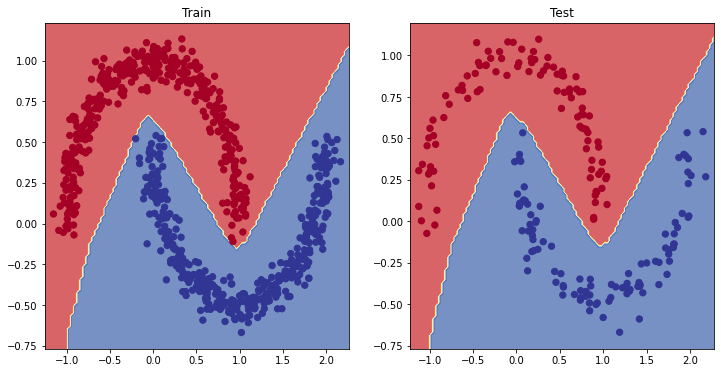

In [14]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)